# Heuristic plot of Approximation Ratio vs number of nodes

In [15]:
import qtensor
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import xarray as xar
mpl.rcParams.update({'font.size': 16})

In [16]:
ls -l ../data

total 4928
-rw-r--r-- 1 plate plate 4683150 Oct 26 13:46 ALL_3r_graphs.json
-rw-r--r-- 1 plate plate    1944 Oct 26 13:46 GW_cost_vs_N.nc
-rw-r--r-- 1 plate plate    6576 Oct 26 13:45 QAOA_cost_vs_N.nc
-rw-r--r-- 1 plate plate    1024 May 30 12:28 QAOA_cost_vs_N.npy
-rw-r--r-- 1 plate plate    2170 May 30 12:28 angles.json
drwxr-xr-x 3 plate plate    4096 Oct 26 13:50 generators/
-rw-r--r-- 1 plate plate  299707 Oct 26 13:43 graph_ensemble_data2.zip
-rw-r--r-- 1 plate plate    1928 Oct 26 13:45 gurobi_cost_vs_N.nc
-rw-r--r-- 1 plate plate     408 May 30 12:28 gurobi_cost_vs_N.npy
drwxr-xr-x 2 plate plate    4096 Oct 26 13:50 large_scale/
-rw-r--r-- 1 plate plate    3243 Oct 26 13:50 magic_stickynote11_SMOOTH.json
-rwxr-xr-x 1 plate plate    7068 Oct 26 13:50 magic_stickynote_allregular.json*
-rw-r--r-- 1 plate plate    5612 Oct 26 13:46 magic_stickynote_connectivity.json


In [17]:
SEEDS = range(10, 26)
SIZES = [2**x for x in range(3, 9)]

In [18]:
graphs = np.array([
    [nx.random_regular_graph(3, N, seed=seed) for seed in SEEDS]
    for N in SIZES
], dtype=object)

## Read gurobi solution data

In [19]:
gurobi_sol = xar.open_dataarray('../data/gurobi_cost_vs_N.nc')
qaoa_sol = xar.open_dataarray('../data/QAOA_cost_vs_N.nc')
gurobi_sol.shape,  qaoa_sol.shape

((6, 32), (4, 6, 32))

## Plot data
### Helper functions

In [20]:
def get_colors(num=2, offset=0.25, cmap=mpl.cm.gnuplot2):
    """
    returns:
        Array of len ``num``.
    """
    
    return np.array([cmap(x) for x in np.linspace(offset, 1-offset, num)])

c_prim, c_sec = get_colors(offset=0.25)

In [21]:
from mpl_toolkits.axes_grid1 import Divider, Size

def add_sized_axis(fig, axsize, right=False):
    # The first items are for padding and the second items are for the axes.
    # sizes are in inch.
    h = [Size.Fixed(1.0), Size.Fixed(axsize[0]), Size.Fixed(.5)]
    if right:
        h = list(reversed(h))
    v = [Size.Fixed(0.7), Size.Fixed(axsize[1])]

    divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
    # The width and height of the rectangle are ignored.

    ax = fig.add_axes(divider.get_position(),
                      axes_locator=divider.new_locator(nx=1, ny=1))

In [22]:
def plot_with_range(x, data, color,
                    label='Average',
                    shade_label='',
                    alpha=0.15
                   ):
    mi = np.nanmin(data, -1)
    av = np.nanmean(data, -1)
    ma = np.nanmax(data, -1)

    plt.plot(x, av,'o-', label=label, color=color)
    #plt.plot(np.arange(1,12),maxAR,'.-',label='Max', color=c_prim)
    #plt.plot(np.arange(1,12),minAR,'.-', label='Minimum', color=c_prim)
    plt.fill_between(x, mi, ma, color=color, alpha=alpha, label=shade_label)
   

### Plotting functions

In [23]:
def plot_ar_p(x, data, c_prim, c_sec,
              alpha=0.15, axsize=(6, 6/1.618),
              guarantees=True
             ):
    margin = (0.2, 0.2)
    fig = plt.figure(figsize=(axsize[0]+1.5, axsize[1]+.8))
    add_sized_axis(fig, axsize, right=True)
    #plt.subplots_adjust(left=0.15,right=0.85)
    colors_p = iter(get_colors(num=len(data), offset=0.2))
    for i, data_p in enumerate(data):
        p = i+1
        plot_with_range(x, data_p,
                        color=next(colors_p),
                        label=f'p={p}'
                       )

    ax = plt.gca()
    plt.xlabel('N')
    plt.ylabel('Approximation ratio')
    plt.legend(title='Averages', loc='upper right', ncol=2)
    
    plt.grid(alpha=0.3)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    plt.ylim(0.68, 1.05)
    
    if guarantees:
        colors_p = iter(get_colors(num=len(data), offset=0.2))
        guarantees = [qtensor.tools.BETHE_QAOA_VALUES[str(p)]['val'] for p in range(1, 5)]
        rightpos = max(x)*1.5
        for g_p in guarantees:
            plt.hlines(g_p, max(x)/1.2, rightpos,
                       color=next(colors_p),
                       linestyle='--', linewidth=2)
        plt.xlim(min(x)/1.2, rightpos)
        guarantee_ticks = [np.round(x, 3) for x in guarantees]
        ticks = guarantees + [0.85, 0.90, 0.95, 1.00]
        plt.yticks(ticks=ticks, labels=[np.round(x, 2) for x in ticks])

    return fig

In [27]:
def set_scalar_axis(ax):
    """ plt."""
    from matplotlib.ticker import ScalarFormatter
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())

Number of seeds = 32


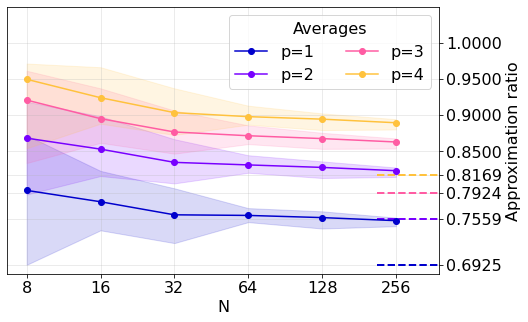

In [28]:
plot_ar_p(SIZES, qaoa_sol/gurobi_sol[:,:len(qaoa_sol.seed)], c_prim, c_sec)
print('Number of seeds =', len(qaoa_sol.seed))
plt.xscale('log', base=2, )
set_scalar_axis(plt.gca())

plt.savefig('./pdf/ar_vs_N.pdf')